In [43]:
import os
import sys
import numpy as np
import laspy as lp
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
import shutil
from collections import Counter
from sklearn.model_selection import StratifiedKFold

In [40]:
input_ALS_folder = '/home/davidhersh/Dropbox/Uni/ThesisHersh/ALS_data'
output_folder = '/media/davidhersh/T7 Shield/pre-processing/tmp'

In [44]:
def copy_folder(input_folder, output_folder=output_folder, point_threshold=2000, plot=True):
    """
    Copy single tree ALS files (ending with _g meaning ground classified) for a specific list of trees if they have a minimum point count
    """
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    # Save figs
    figdir = output_folder.replace('/tmp', '/processing_figures')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    
    # Only copy certain species
    species_to_copy = [
        "PseMen",
        "FagSyl",
        "PinSyl",
        "QueRub",
        "PicAbi",
        "QuePet"
    ]

    files = []
    species_counter = Counter()
    
    for root, dirs, filenames in os.walk(input_folder):
        for filename in filenames:
            try:
                species_name = filename.split('_')[0]
    
                # Study area BR06 has an issue with ground. Do not copy for further processing
                # File format: FagSyl_BR02_04_2019-07-05_q2_ALS-on_g.laz
                study_area = filename.split('_')[1] # BR02
    
                if filename.endswith('ALS-on_g.laz') and species_name in species_to_copy and study_area != "BR06":
                        las = lp.read(os.path.join(root, filename))
                        number_of_nonground_points = len(las.points[las.classification !=2])
                        if number_of_nonground_points >= point_threshold:
                            species_counter[species_name] += 1
                            files.append(os.path.join(root, filename))  # Store full file paths
                            shutil.copyfile(os.path.join(figdir, filename), os.path.join(output_folder, filename))
            except: 
                pass
    print(f'Copying {len(files)} files')
    print(f'Unique species: {species_counter}')
    
    if plot:
        fig, ax = plt.subplots(figsize=(12,8))
        plt.bar(species_counter.keys(), species_counter.values())
        plt.ylabel('Number of trees')
        plt.xlabel('Species')
        plt.title(f"Species with greater than {point_threshold} non-ground points")
        plt.savefig(os.path.join(figdir, f'species_count_greaterthan_{point_threshold}_points.png'), bbox_inches='tight')
        plt.show()
        
    return output_folder, species_counter


Copying 920 files
Unique species: Counter({'FagSyl': 294, 'PseMen': 185, 'PinSyl': 141, 'PicAbi': 121, 'QueRub': 104, 'QuePet': 75})


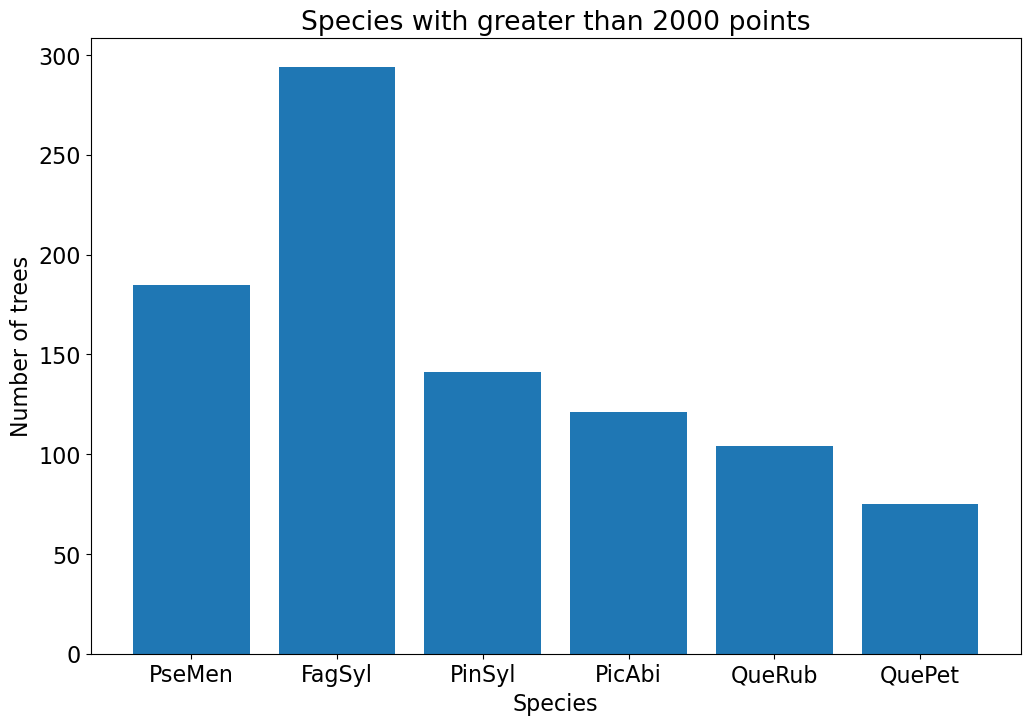

In [45]:
copied_als_folder, species_counter = copy_folder(input_ALS_folder)

In [53]:
def stratified_k_fold_split(input_folder, output_folder, n_splits=5):
    input_folder = copied_als_folder
    output_folder = input_folder.replace('/tmp', '/kfolders')

    files = []
    labels = []
    
    for file in os.listdir(input_folder):
        class_name = file.split('_')[0] #Fagsyl etc...
        files.append(os.path.join(input_folder, file))
        labels.append(class_name)
    class_counts = Counter(labels)
    print(f'Class counts: {class_counts}')
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=32)
    
    train_folders = []
    test_folders = []
    
    for fold, (train_index, test_index) in enumerate(skf.split(files, labels)):
        fold_train_dir = os.path.join(output_folder, f'fold_{fold+1}_train')
        train_folders.append(fold_train_dir)
        fold_test_dir = os.path.join(output_folder, f'fold_{fold+1}_val')
        test_folders.append(fold_test_dir)
        os.makedirs(fold_train_dir, exist_ok=True)
        os.makedirs(fold_test_dir, exist_ok=True)
        
        for train_idx in train_index:
            shutil.copy(files[train_idx], fold_train_dir)
        for test_idx in test_index:
            shutil.copy(files[test_idx], fold_test_dir)
            
    return train_folders, test_folders
    
train_folders, test_folders = stratified_k_fold_split(copied_als_folder, output_folder, n_splits=5)

Class counts: Counter({'FagSyl': 294, 'PseMen': 185, 'PinSyl': 141, 'PicAbi': 121, 'QueRub': 104, 'QuePet': 75})


In [54]:
print(train_folders)

['/media/davidhersh/T7 Shield/pre-processing/kfolders/fold_1_train', '/media/davidhersh/T7 Shield/pre-processing/kfolders/fold_2_train', '/media/davidhersh/T7 Shield/pre-processing/kfolders/fold_3_train', '/media/davidhersh/T7 Shield/pre-processing/kfolders/fold_4_train', '/media/davidhersh/T7 Shield/pre-processing/kfolders/fold_5_train']


In [ ]:
# Augment each folder

# Convert to KPConv repository dataset format

# Loop over each dataset and run trainNeuesPalaisTrees.py
# Need to pass config parameters here and update class_w